# Preprocessing

In [2]:
import numpy as np
from numpy import random as rd
from scipy import stats
import pandas as pd
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.grid_search import GridSearchCV
from importlib import reload

import UserFeature
import EventFeature
import PairwiseFeature
import Join
import MatrixFactorization
import NDCG

%matplotlib inline

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
def read(name):
    # 各データの読み出し
    return pd.read_csv('\'{}.tsv\'.txt'.format(name), delimiter='\t')

log_data = read('log')               # ユーザーの行動ログデータ
event_data = read('events')         # イベントの属性データ
user_data = read('users')           # ユーザーのデモグラ情報
user_test = read('test')            # 評価対象ユーザー
sample_data = read('sample_submit')  # 応募用サンプルファイル

In [4]:
# 時刻データを全てdatetime型に変換
log_data.time_stamp = pd.to_datetime(log_data.time_stamp)
event_data.event_start_at = pd.to_datetime(event_data.event_start_at)
event_data.first_published_at = pd.to_datetime(event_data.first_published_at)
user_data.created_on = pd.to_datetime(user_data.created_on)

# ユーザーの性別を0(女性),1(男性)に変換
user_data.gender = user_data.gender.apply(lambda x: 0 if x=='女性' else 1)

# ユーザーの居住地を'prefecture'から'residence'に変更
user_data = user_data.rename(columns={'prefecture': 'residence'})

# user_testのインデックスに'user_id'を指定
user_test = user_test.set_index('user_id')

# 全データの'user_id'を含むユーザーのデモグラ情報データを作成し、インデックスに'user_id'を指定
user_log = pd.DataFrame({'user_id':log_data.user_id.unique()}).set_index('user_id')
user_data = user_data.set_index('user_id').join([user_log, user_test], how='outer')

# user_dataのnullを補完
user_data = user_data.fillna({'age':user_data.age.median(),
                              'gender':user_data.gender.mode()[0],
                              'residence':'東京都',
                              'created_on':pd.to_datetime(user_data.created_on).max()})

# event_dataの年齢制限が0の部分に中央値を代入
event_data.female_age_lower[event_data.female_age_lower==0] = event_data.female_age_lower.median()
event_data.female_age_upper[event_data.female_age_upper==0] = event_data.female_age_upper.median()
event_data.male_age_lower[event_data.male_age_lower==0] = event_data.male_age_lower.median()
event_data.male_age_upper[event_data.male_age_upper==0] = event_data.male_age_upper.median()

# event_dataのnullを補完
event_data = event_data.fillna({'female_age_upper':event_data.female_age_upper.median(),
                                'male_age_upper':event_data.male_age_upper.median(),
                                'female_price':event_data.female_price.median(),
                                'male_price':event_data.male_price.median()})

# log_dataのnullを補完
log_data = log_data.fillna({'num_of_people':0, 'total_price':0})

# event_dataのインデックスに'event_id'を指定
event_data = event_data.set_index('event_id')

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:30

In [5]:
def area(data):
    # 都道府県を各地方に振り分ける
    data = data.apply(lambda x:'北海道' if x=='北海道'
                           else('東北' if (x=='青森県' or x=='岩手県' or x=='宮城県' or x=='秋田県' or x=='山形県' or x=='福島県')
                           else('関東' if (x=='茨城県' or x=='栃木県' or x=='群馬県' or x=='埼玉県' or x=='千葉県' or x=='東京都' or x=='神奈川県')
                           else('中部' if (x=='新潟県' or x=='富山県' or x=='石川県' or x=='福井県' or x=='山梨県' or x=='長野県' or x=='岐阜県' or x=='静岡県' or x=='愛知県')
                           else('近畿' if (x=='京都府' or x=='大阪府' or x=='兵庫県' or x=='滋賀県' or x=='奈良県' or x=='和歌山県' or x=='三重県')
                           else('中国' if (x=='鳥取県' or x=='島根県' or x=='岡山県' or x=='広島県' or x=='山口県')
                           else('四国' if (x=='高知県' or x=='香川県' or x=='徳島県' or x=='愛媛県')
                           else '九州' )))))))
    return data

In [6]:
#user_data.residence = area(user_data.residence)
#event_data.prefecture = area(event_data.prefecture)

In [7]:
# user_idとevent_idで紐づけたmerge_dataを作成
merge_data = pd.merge(pd.merge(log_data, event_data.reset_index(), how='left'), user_data.reset_index(), how='left')

# 'time_stamp'をインデックスに指定
merge_data = merge_data.set_index('time_stamp')

In [8]:
def training_hist(data, r):
    # 比率rで入力データを訓練用過去データと訓練データに分割
    hist_length = int(len(data)*r)
    train_length = len(data)-hist_length
    hist_data = data.iloc[:hist_length, :].reset_index().set_index(['user_id', 'event_id'])
    log_data = data.iloc[train_length-1:, :].sort_index()
    return hist_data, log_data

def validation_hist(data):
    # 2017/9/17以前のデータを検証用過去データ、2017/9/18以降のデータを検証用データとして抽出
    hist_data = data[data.index<'2017-9-18'].reset_index().set_index(['user_id', 'event_id'])
    log_data = data[data.index>='2017-9-18'].reset_index()
    return hist_data, log_data

def test_hist(data):
    # 全データを評価用過去データとして抽出
    return data.reset_index().set_index(['user_id', 'event_id'])

In [9]:
v_train_hist, v_train_data = training_hist(merge_data[merge_data.index<'2017-9-18'], 0.8)
t_train_hist, t_train_data = training_hist(merge_data, 0.8)
valid_hist, valid_data = validation_hist(merge_data)
test_hist = test_hist(merge_data)

In [10]:
def training_user(data):
    # 1週間に1回以上のペースで行動していたユーザーを選出
    d_week = ((data.iloc[-1].name-data.iloc[0].name)/7).days
    action_num = data.groupby('user_id')[['action_type']].count()
    return action_num[action_num.action_type>=d_week].index.values

def validation_user(data, num):
    # '2017/9/18'以降に行動したユーザーを選出
    user = data.user_id.unique()
    return rd.choice(user, num, replace=False)

In [11]:
v_train_user = training_user(v_train_data)
t_train_user = training_user(t_train_data)
valid_user = validation_user(valid_data, len(user_test))
test_user = user_test.index.values

In [12]:
def training_event(user, data):
    # 選出されたユーザーが抽出された期間内に行動したイベントの中で、'action_type'の合計値が上位10%のイベントを訓練用の推薦イベントとして抽出
    df_user = pd.DataFrame(index=pd.Index(user, name='user_id'))
    df_event = df_user.join(data.reset_index().set_index('user_id')).groupby('event_id')[['action_type']].sum()
    famous_event_action = stats.scoreatpercentile(df_event, 90)
    return df_event[df_event.action_type>=famous_event_action].index.values

def validation_event(data):
    # 2017/9/18~23に開催されるイベントを検証用の推薦イベントとして抽出
    data = data.reset_index().set_index('event_start_at')
    return data[(data.index>='2017-9-18')&(data.index<'2017-9-24')].event_id.values

def test_event(data):
    # 2017/9/24~30に開催されるイベントを評価用の推薦イベントとして抽出
    data = data.reset_index().set_index('event_start_at')
    return data[data.index>='2017-9-24'].event_id.values

In [13]:
v_train_event = training_event(v_train_user, v_train_data)
t_train_event = training_event(t_train_user, t_train_data)
valid_event = validation_event(event_data)
test_event = test_event(event_data)

In [14]:
def multi_index(user, event):
    # 'user_id'と'event_id'をインデックスに持つDFを作成
    return pd.DataFrame(index=pd.MultiIndex.from_product([user, event], names=['user_id', 'event_id']))

In [15]:
v_train_index = multi_index(v_train_user, v_train_event)
t_train_index = multi_index(t_train_user, t_train_event)
valid_index = multi_index(valid_user, valid_event)
test_index = multi_index(test_user, test_event)

In [16]:
# モジュールの更新
reload(UserFeature)
reload(EventFeature)
reload(PairwiseFeature)
reload(Join)

<module 'Join' from '/Users/shohei/Desktop/Shohei/Python/Competitions/EventRecommendEngine/Join.py'>

In [17]:
# 説明変数（特徴量）のDFを作成
X_v_train = Join.Join(v_train_index, user_data, event_data, v_train_hist).extract()
X_valid = Join.Join(valid_index, user_data, event_data, valid_hist).extract()

In [18]:
X_valid.head()

age  gender  action_hist_user_1  action_hist_user_2  \
user_id event_id                                                         
12548   143632    29.0     0.0               140.0               140.0   
        143676    29.0     0.0               140.0               140.0   
        143677    29.0     0.0               140.0               140.0   
        143686    29.0     0.0               140.0               140.0   
        143687    29.0     0.0               140.0               140.0   

                  action_hist_user_3  action_hist_user_sum  fl_20  fl_21  \
user_id event_id                                                           
12548   143632                 140.0                 166.0      0      0   
        143676                 140.0                 166.0      0      0   
        143677                 140.0                 166.0      0      0   
        143686                 140.0                 166.0      0      0   
        143687                 140.0                 166.0      0      0   

                  fl_22  fl_23            ...             action_hist_event_2  \
user_id event_id                          ...                                   
12548   143632        1      0            ...                             3.0   
        143676        0      0            ...                             3.0   
        143677        0      0            ...                             2.0   
        143686        0      0            ...                             3.0   
        143687        0      0            ...                             0.0   

                  action_hist_event_3  action_hist_event_sum  \
user_id event_id                                               
12548   143632                    3.0                    3.0   
        143676                    3.0                    4.0   
        143677                    2.0                    3.0   
        143686                    3.0                    4.0   
        143687                    0.0                    0.0   

                  resistration_period  from_at_prefecture  at_user_hist  \
user_id event_id                                                          
12548   143632                    687                   0             1   
        143676                    685                   0             1   
        143677                    690                   0             1   
        143686                    685                   0             1   
        143687                    690                   0             1   

                  action_hist_pairwise_1  action_hist_pairwise_2  \
user_id event_id                                                   
12548   143632                       0.0                     0.0   
        143676                       0.0                     0.0   
        143677                       0.0                     0.0   
        143686                       0.0                     0.0   
        143687                       0.0                     0.0   

                  action_hist_pairwise_3  action_hist_pairwise_sum  
user_id event_id                                                    
12548   143632                       0.0                       0.0  
        143676                       0.0                       0.0  
        143677                       0.0                       0.0  
        143686                       0.0                       0.0  
        143687                       0.0                       0.0  

[5 rows x 191 columns]

In [19]:
def scoring(user, event, data, alpha, beta, iterations):
    # 目的変数の不足部分をスコアリングしたDFを作成
    MI = pd.MultiIndex.from_product([user, event], names=['user_id', 'event_id'])
    df = pd.DataFrame(index=MI).join(data.set_index(['user_id', 'event_id']))[['action_type']]
    df = df.groupby(level=[0, 1]).max().reset_index()
    df = df.pivot(index='user_id', columns='event_id', values='action_type').fillna(0)
    R = df.as_matrix()
    mf = MatrixFactorization.MF(R, K=2, alpha=alpha, beta=beta, iterations=iterations)
    training_process = mf.train()
    R_pred = mf.full_matrix()
    df_pred = pd.DataFrame(R_pred, index=df.index, columns=df.columns).reset_index()
    df_pred = pd.melt(df_pred, id_vars='user_id', value_vars=list(df_pred.columns[1:]),
                      var_name='event_id', value_name='action_type').set_index(['user_id', 'event_id']).sort_index()
    return df_pred

In [20]:
y_v_train = scoring(v_train_user, v_train_event, v_train_data, 0.1, 0.01, 10)
y_valid = scoring(valid_user, valid_event, valid_data, 0.1, 0.01, 10)

# Learning

In [21]:
def predict(model, X_train, y_train, X_test):
    mod = model
    mod.fit(X_train, y_train)
    return mod.predict(X_test)

In [76]:
model = Ridge(fit_intercept=False, normalize=True)
parameters = {'alpha': [3.0, 3.5, 4.0, 4.5, 5.0]}
model_grid = GridSearchCV(model, parameters, cv=3)
model_grid.fit(X_v_train, y_v_train)
model_grid_best = model_grid.best_estimator_
print("Best Model Parameter: ", model_grid.best_params_)

Best Model Parameter:  {'alpha': 5.0}


In [97]:
nor = Normalizer()
std = StandardScaler()
lr = LinearRegression()
rid = Ridge()
rfr = RandomForestRegressor(max_depth=10)
pl = Pipeline(steps=[('preprocessing', nor), ('model', rid)])
pred_valid = predict(pl, X_v_train, y_v_train.action_type.values, X_valid)

In [77]:
pred_valid = model_grid_best.predict(X_valid)

In [78]:
def convert(data):
    return data.apply(lambda x:0 if x<0.5 else(1 if 0.5<=x<1.5 else(2 if 1.5<=x<2.5 else 3)))

In [79]:
# 関連度を0,1,2,3に変換
y_valid.action_type = convert(y_valid.action_type)

In [80]:
NDCG.ndcg2(y_valid.action_type.values, pred_valid, k=20)

array([0.42857143])

In [25]:
NDCG.ndcg2(y_valid.action_type.values, pred_valid, k=20)

0.38798856010466926

In [60]:
true_sort = np.sort(y_valid.action_type.values)[::-1]
valid_sort = np.sort(pred_valid)[::-1]
pred_index = np.argsort(pred_valid)[::-1]
pred_sort = y_valid.action_type.values[pred_index]

In [61]:
print('　　　正しいランキング', true_sort[:20])
print('　　　　予測ランキング', pred_sort[:20])
print('予測データのランキング', valid_sort[:20])

　　　正しいランキング [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
　　　　予測ランキング [3 2 2 2 3 2 1 2 2 2 1 2 1 2 3 2 2 2 3 2]
予測データのランキング [3.52581129 3.45933392 3.36972521 3.32312788 3.32312788 3.32312788
 3.32312788 3.32312788 3.32312788 3.32312788 3.32312788 3.32312788
 3.32312788 3.32312788 3.32312788 3.32312788 3.32312788 3.32312788
 3.32312788 3.32312788]


In [63]:
coef = sorted(dict(zip(X_v_train.columns, rid.coef_)).items(), key=lambda x: -x[1])
x_values = np.linspace(1, len(coef), len(coef))
x_name = [coef_i[0] for coef_i in coef]
y_values = [coef_i[1] for coef_i in coef]
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 8
plt.barh(x_values, y_values)
plt.xlabel('weight')
plt.yticks(x_values, x_name)
#plt.ylim(0, )
plt.show()

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [34]:
pd.DataFrame({'feature':x_name, 'weight':np.abs(y_values)}).set_index('feature').sort_values(by='weight', ascending=False)

,weight
feature,
action_hist_event_sum,18.959246
action_hist_user_sum,16.150909
action_hist_event_2,10.954336
action_hist_event_3,10.954336
action_hist_event_1,10.954336
fu_29.0,8.031296
at_user_hist_東京都,7.153915
action_hist_user_3,6.469191
action_hist_user_1,6.469191


# Predicting

In [35]:
X_t_train = Join.Join(t_train_index, user_data, event_data, t_train_hist).extract()
X_test = Join.Join(test_index, user_data, event_data, test_hist).extract()
y_t_train = scoring(t_train_user, t_train_event, t_train_data, 0.1, 0.01, 10)

In [36]:
# 作成したモデルから評価対象ユーザーに対する推薦イベントの行動ランキングを作成
#pl.fit(X_t_train, y_t_train)
#pred_test = pl.predict(X_test)
model_grid_best.fit(X_t_train, y_t_train)
pred_test = model_grid_best.predict(X_test)

# 予測した全データをDFに変換
pred_data = pd.DataFrame(pred_test, index=test_index.index, columns=['action_type']).reset_index('event_id')

# 各ユーザー毎に上位20件のイベントを残した提出用DFを作成
user_id = user_test.index.values
submit_data = pd.concat([pred_data.loc[i].sort_values(by='action_type', ascending=False).iloc[:20, :].reset_index() for i in user_id],
                        ignore_index=True)

NameError: name 'convert' is not defined

In [38]:
# 関連度を0,1,2,3に変換
submit_data.action_type = convert(submit_data.action_type)

# 提出用DFをtsvファイルにして保存
submit_data.to_csv('submit.tsv', sep='\t', index=False, header=False)

In [39]:
submit_data

,user_id,event_id,action_type
0,1,147449,3
1,1,149522,3
2,1,145651,3
3,1,155809,3
4,1,147218,3
5,1,147717,3
6,1,147137,3
7,1,145388,3
8,1,151617,2
9,1,157671,2


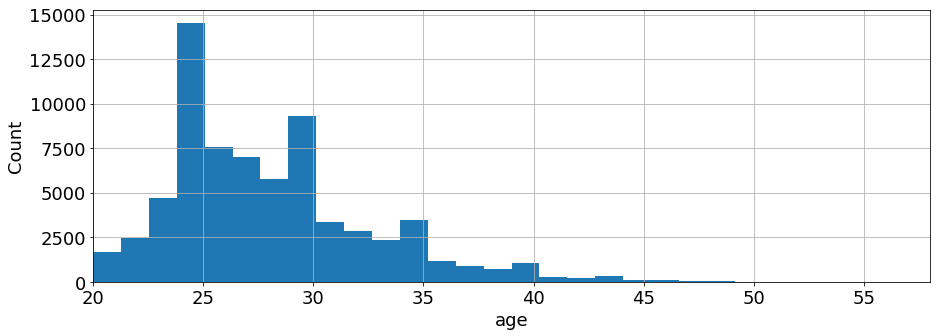

In [101]:
plt.rcParams['font.size']=18
user_data.age.hist(bins=30, figsize=(15, 5))
plt.xlabel('age')
plt.ylabel('Count')
plt.xlim(user_data.age.min(), user_data.age.max())
plt.show()

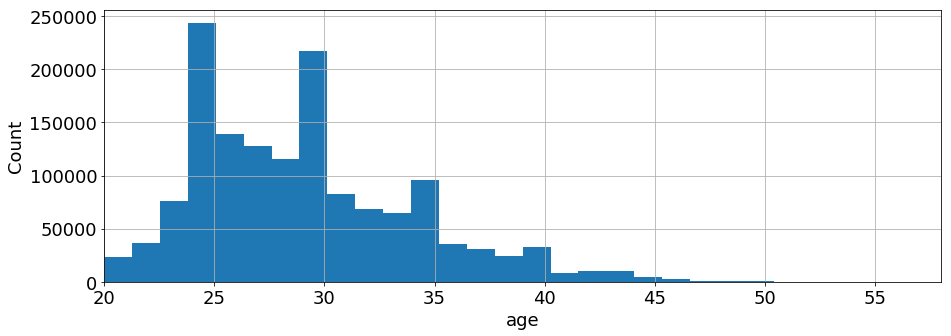

In [49]:
plt.rcParams['font.size']=18
merge_data.age.hist(bins=30, figsize=(15, 5))
plt.xlabel('age')
plt.ylabel('Count')
plt.xlim(merge_data.age.min(), merge_data.age.max())
plt.show()

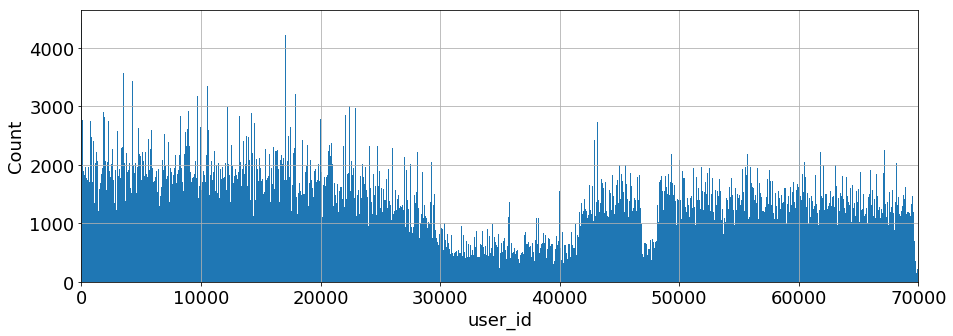

In [46]:
plt.rcParams['font.size']=18
log_data.user_id.hist(bins=1000, figsize=(15, 5))
plt.xlabel('user_id')
plt.ylabel('Count')
plt.xlim(log_data.user_id.min(), log_data.user_id.max())
plt.show()

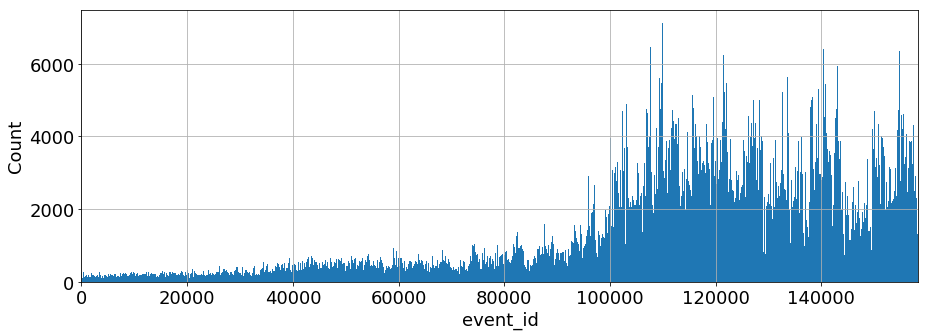

In [47]:
plt.rcParams['font.size']=18
log_data.event_id.hist(bins=1000, figsize=(15, 5))
plt.xlabel('event_id')
plt.ylabel('Count')
plt.xlim(log_data.event_id.min(), log_data.event_id.max())
plt.show()